## Importing stuffs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Write a program which does thinning on a downsampled image (lena.bmp).

#### Downsampling Lena from 512x512 to 64x64: 

* Binarize the benchmark image lena as in HW2, then using 8x8 blocks as a unit, * take the topmost-left pixel as the downsampled data.
* You have to use 4-connected neighborhood detection.
* You can use any programing language to implement homework, however, you'll get zero point if you just call existing library.

### Importing image and binarizing

In [2]:
lena=cv2.imread('lena.bmp')

In [3]:
bi_img = np.array([[[ 0 if lena[i, j, c] < 128 else 1 for c in range(lena.shape[2])] 
                           for j in range(int(lena.shape[1]))] 
                           for i in range(int(lena.shape[0]))], dtype='uint8')

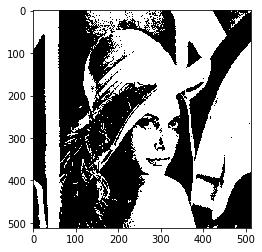

In [4]:
plt.imshow(bi_img*255)

### Downsampling

In [5]:
def downsampling(img,size):
    H=img.shape[0]
    W=img.shape[1]
    new_H=int(H/size[0])
    new_W=int(W/size[1])
    new_img=np.zeros((new_H,new_W), dtype=np.int)
    
    for i in range(new_H):
        for j in range(new_W):
            new_img[i,j]=img[i*size[0]][j*size[1]][0]
            
    re_img=np.stack((new_img, new_img, new_img), axis = -1) 
    return re_img

In [6]:
small_img=downsampling(bi_img,(8,8))

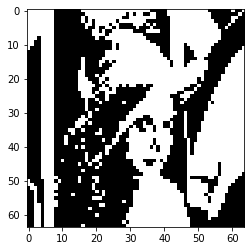

In [7]:
plt.imshow(small_img*255)

### Yokoi connectivity number

In [8]:
def QRS(b,c,d,e):
    if((b==c) & ((d!=b) | (e != b))):
        return "Q"
    if(b!=c):
        return "S"
    if((b==c) & ((d==b) & (e == b))):
        return "R"
    

In [9]:
def yokoi(im,l,p):
    neighbors=[QRS(im[l,p],im[l,p+1],im[l-1,p+1],im[l-1,p])
              ,QRS(im[l,p],im[l-1,p],im[l-1,p-1],im[l,p-1])
              ,QRS(im[l,p],im[l,p-1],im[l+1,p-1],im[l+1,p])
              ,QRS(im[l,p],im[l+1,p],im[l+1,p+1],im[l,p+1])]
    if (neighbors.count("S")==4):
        return 0
    elif(neighbors.count("R")==4):
        return 5
    else:
        return neighbors.count("Q")

In [10]:
def yokoi_operation(img):
    H=img.shape[0]
    W=img.shape[1]
    
    label_img=np.zeros((H,W), dtype=np.int)
    pad_img=np.pad(img, 1, mode='constant',constant_values=10)
    for l in range(H):
        for p in range(W):
            ll=l+1
            pp=p+1
            if(img[l,p]==1):
                label_img[l,p]=yokoi(pad_img,ll,pp)
    return label_img

#### Transforming 3D (RGB) image array to 2D image array

In [11]:
def One_dim(img):
    H=img.shape[0]
    W=img.shape[1]
    new_img=np.zeros((H,W), dtype=np.int)
    for i in range(H):
        for j in range(W):
            new_img[i][j]=small_img[i][j][0]
    return new_img

In [12]:
small_2D_img=One_dim(small_img)

#### Testing yokoi operation  

In [13]:
yokoi_label=yokoi_operation(small_2D_img)

In [14]:
def print_label(arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if(arr[i,j]==0):
                print(" ",end='')
            else:
                print(arr[i,j],end='')
        print()

### Pair Relationship Operator

In [15]:
def h2_fun(a,m):
    if(a==m):
        return 1
    else:
        return 0

In [16]:
def PairRelationship(im,ll,pp):
    count=0
    neighbors=[im[ll,pp+1],im[ll-1,pp],im[ll,pp-1],im[ll+1,pp]]
    for i in neighbors:
        count=h2_fun(i,1)+count
    if((count!=0) & (im[ll,pp]==1)):
        return "p" #p
    elif((count==0) | (im[ll,pp]!=1)):
        return "q" #q
    else:
        return 0

In [17]:
def unpadding(img,width):
    H=img.shape[0]-2*width
    W=img.shape[1]-2*width
    new_img=np.zeros((H,W), dtype=np.int)
    for i in range(H):
        for j in range(W):
            new_img[i,j]=img[i+width,j+width]
    return new_img

### Main shrinking function

In [18]:
def Shrinking_fun(img_arr):
    H=img_arr.shape[0]
    W=img_arr.shape[1]
    i=0 #iteration num
    change=0 #checking if the image
    new_img=np.copy(img_arr)
    
    while(i==0 or change==1):
        change=0
        label_img=yokoi_operation(new_img)
        pair_img=np.zeros((H,W), dtype='U')
        pad_label=np.pad(label_img, 1, mode='constant',constant_values=0)
        new_img_pad=np.pad(new_img, 1, mode='constant',constant_values=0)
        
        for l in range(H):
            for p in range(W):
                if(new_img[l,p]==1):
                    ll=l+1
                    pp=p+1
                    pair_img[l,p]=PairRelationship(pad_label,ll,pp)
        
        for l in range(H):
            for p in range(W):
                if(pair_img[l,p]=="p"):
                    ll=l+1
                    pp=p+1
                    value=yokoi(new_img_pad,ll,pp)
                    if(value==1):
                        new_img_pad[ll,pp]=0
                        change=1
                    new_img=unpadding(new_img_pad,1)
        i=i+1
        
    return new_img, i

### Main codes

In [19]:
small_2D_img=One_dim(small_img)

In [20]:
shrinking_2D_img, iter_num=Shrinking_fun(small_2D_img)

#### Print iteration number

In [21]:
iter_num

7

#### Showing the image

In [22]:
thin_2D=shrinking_2D_img*255

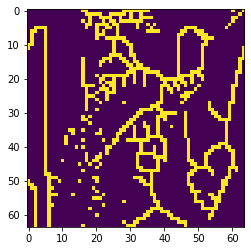

In [23]:
plt.imshow(thin_2D)

### Export the image

In [24]:
thinning_img=np.stack((thin_2D, thin_2D, thin_2D), axis = -1)

In [25]:
cv2.imwrite('HW7_thinning_img.jpg', thinning_img)

True